# Example 3 : Basic Analysis and Identifying Potential Events

In this notebook, we will go through a basic prescription for analyzing MUSIC data. This typically involves a series of steps to search for the events of interest within the larger dataset. Finding the proverbial needle in the haystack (typically, by trying to reduce the size of the "haystack" first). For example, one set of steps could look something like

- Cut Pile-up Events
- Normalization
- Remove Bulk of Unreacted Beam Events
- Apply Cuts in Different Strips
- Plot Traces

Let's work through these steps using test MUSIC data and see the effect of each step on the dataset. First, our usual notebook setup.

<div class="alert alert-block alert-info">
Is this the "best" order for these operations? It depends on what kind of experiment you performed. For example, in the test data, we are looking for fusion events from $^{20}$Ne beam on CH$_{4}$ gas. One potential problem being, some elastic scatter reactions will look very much like fusions. So, an extra step might involve using the left and right anode strips (not summing them) to get the multiplicty in the strips for certain events. So, take the above perscription as an idea but not something set in stone.
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 # bigger figures

# Use more REVTEX-esque fonts
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"

# Use UPROOT and Pull the Data Into a Pandas Dataframe

Following our work in example 2, we will use uproot to read the test_music_data.ROOT file and build a pandas dataframe.

In [2]:
import uproot

In [3]:
file = uproot.open("test_music_data.root")
tree = file['tree']
branches = tree.arrays()

One slight change we will make here is in addition to pulling the individual strip information into the dataframe, we will also bring the grid information too. The Frisch grid signal is similar to the total energy of the given event (so we can use it as an additional source of information to help identify the reactions we are looking for).

In [4]:
dict_branches = {}

# strip0 first
dict_branches.update({'s0':branches['strip0'][branches['seg'] == 1]})
# segmented anode, left first then right
for i in range(1,17):
    dict_branches.update({'s%iL' % i : branches['edepl'][branches['seg'] == i]})
    dict_branches.update({'s%iR' % i  : branches['edepr'][branches['seg'] == i]})
# strip17
dict_branches.update({'s17':branches['strip17'][branches['seg'] == 1]})
# grid last
dict_branches.update({'grid':branches['grid'][branches['seg'] == 1]})

In [5]:
df = pd.DataFrame(dict_branches)

df

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17,grid
0,1003.0,366.0,50.0,35.0,366.0,387.0,33.0,42.0,335.0,377.0,...,463.0,34.0,35.0,457.0,462.0,33.0,49.0,445.0,402.0,1522.0
1,1091.0,356.0,41.0,37.0,366.0,376.0,32.0,36.0,361.0,368.0,...,429.0,37.0,41.0,522.0,470.0,32.0,40.0,482.0,380.0,1468.0
2,1083.0,364.0,62.0,36.0,359.0,371.0,35.0,38.0,372.0,365.0,...,447.0,37.0,38.0,501.0,471.0,32.0,39.0,483.0,402.0,1421.0
3,1002.0,362.0,43.0,37.0,341.0,359.0,35.0,37.0,380.0,411.0,...,436.0,36.0,37.0,442.0,470.0,33.0,37.0,467.0,400.0,1450.0
4,1015.0,352.0,41.0,37.0,361.0,377.0,33.0,39.0,382.0,409.0,...,444.0,33.0,37.0,441.0,442.0,34.0,43.0,463.0,366.0,1487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,338.0,63.0,36.0,360.0,381.0,37.0,36.0,377.0,419.0,...,425.0,39.0,33.0,434.0,419.0,35.0,39.0,459.0,403.0,1592.0
267825,969.0,325.0,41.0,36.0,360.0,387.0,35.0,36.0,363.0,406.0,...,437.0,38.0,36.0,460.0,448.0,34.0,38.0,479.0,384.0,1559.0
267826,958.0,327.0,49.0,40.0,355.0,362.0,32.0,37.0,361.0,401.0,...,423.0,36.0,34.0,447.0,420.0,36.0,46.0,451.0,398.0,1439.0
267827,1006.0,344.0,39.0,41.0,330.0,395.0,35.0,36.0,364.0,419.0,...,436.0,35.0,39.0,459.0,456.0,33.0,53.0,389.0,393.0,1524.0


Now that we have our data in a dataframe, we will first remove the pile-up events.

# Cut Pile-Up Events Using Strip 0

Pile-up events occur from two or more beam particles entering the detector at the same (or nearly the same) time. To remove these events, we typically use Strip 0 of the anode (being the first strip beam passes through, it will "see" the most beam-like events). First, let's take a look at Strip 0.

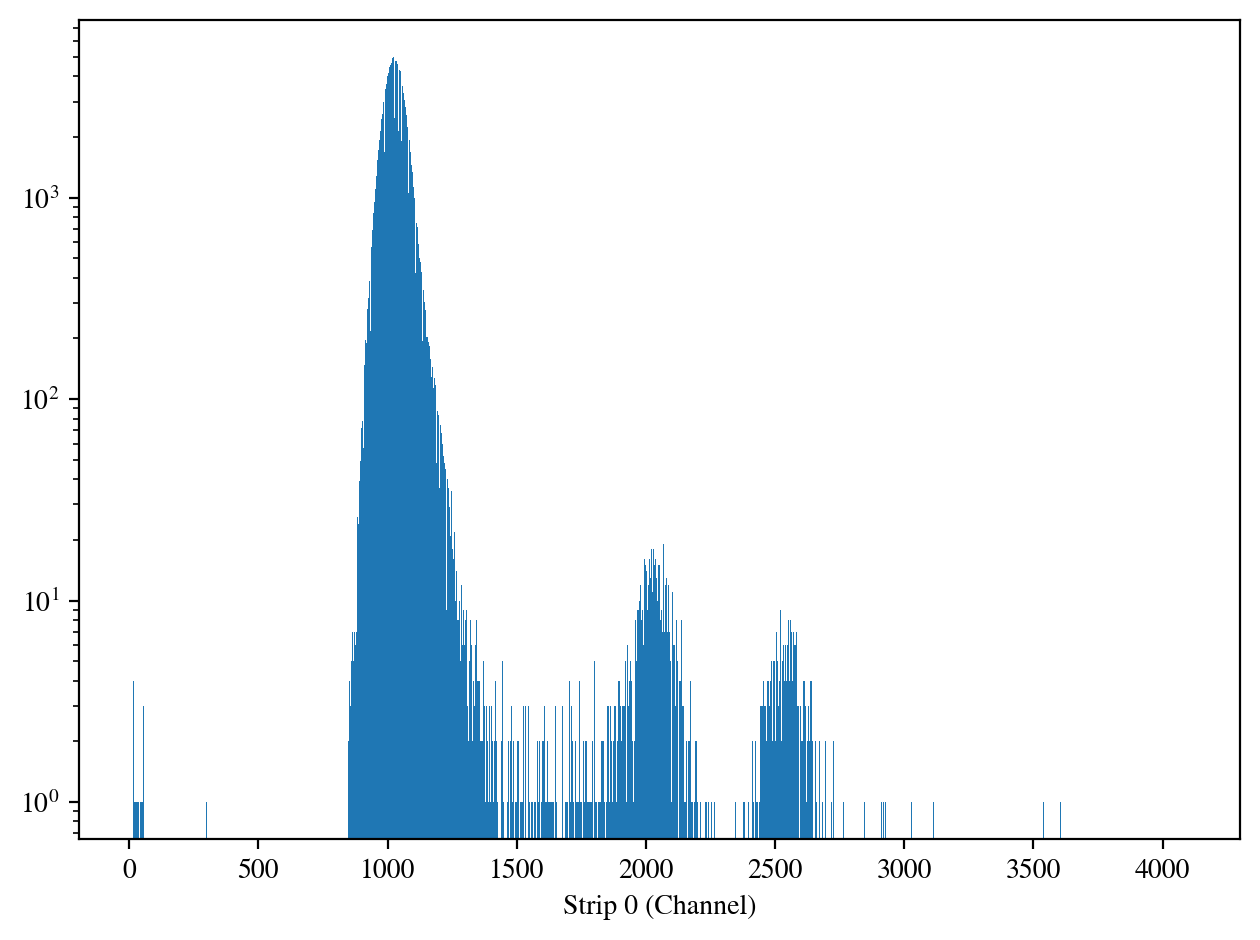

In [6]:
plt.hist(df['s0'], bins='auto')
plt.xlabel('Strip 0 (Channel)')

plt.yscale('log')

plt.tight_layout()
plt.show()

We see a large peak around channel 1000, and the next "most prominent" peak is around channel 2000. If our beam is the peak at channel 1000, then two particles of the beam entering MUSIC at the same time will give a $\Delta$E of around 2000. These are the pile-up events that we wish to remove from our dataset. For this kind of simple cut (1D cut) we can use the pandas drop function just like we did in the previous example. However, we are left with one important choice, where to place the upper and lower limits for the cut. Here, since this dataset is very small (statistics are not great) when we put the y-axis on a log scale combined with the choice of the auto binning from numpy makes it appear as though our "beam peak" around channel 1000 is sufficently distinct from the nearest "large" peak at channel 2000. For real datasets, with much larger statistics, this would be highly unlikley and a fair amount of thought needs to go into where to make the cuts. 

For example, you probably would want to fit the two peaks (at channel 1000 and 2000) with a Gaussian, then plot those fits on top of the histogram here to aid in placing the upper and lower limits of the cut. Here, we only need to remember that the matplotlib hist function uses numpy to get the bin locations and counts. Using the fitting tools in SciPy, we can take those bins and count information, and fit it with a Gaussian. First, let's define the Gaussian function.

In [7]:
def gauss(x, a, mu, sigma):
    ''' Non-normalized Gaussian function.
    
    Parameters
    ----------
    x : float
        Point to evaluate function at.
    a : float
        Height of curve at center.
    mu : float
        Location of center of curve.
    sigma : float
        Standard deviation.
            
    Returns
    -------
    out : float
        Value of function.
    '''
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

In [8]:
from scipy.optimize import curve_fit

From SciPy we will use the curve_fit function in the optimize toolset. From the function we just defined (gauss) we want SciPy to optimize the "a", "mu" and "sigma" parameters. This means we will need two sets of initial guesses (one for the channel 1000 peak and the other for the channel 2000 peak). Remember, the initial guess does require some care as curve_fit uses non-linear least squares approach.

Let's get the explicit bin location and counts from our histogram plot. Then, to make things easier, we will get the center of the bins (matplotlib hist gives the left edge of the bin, except for the final bin where it give the right edge). Then use curve_fit to optimize parameters to fit the two peaks.

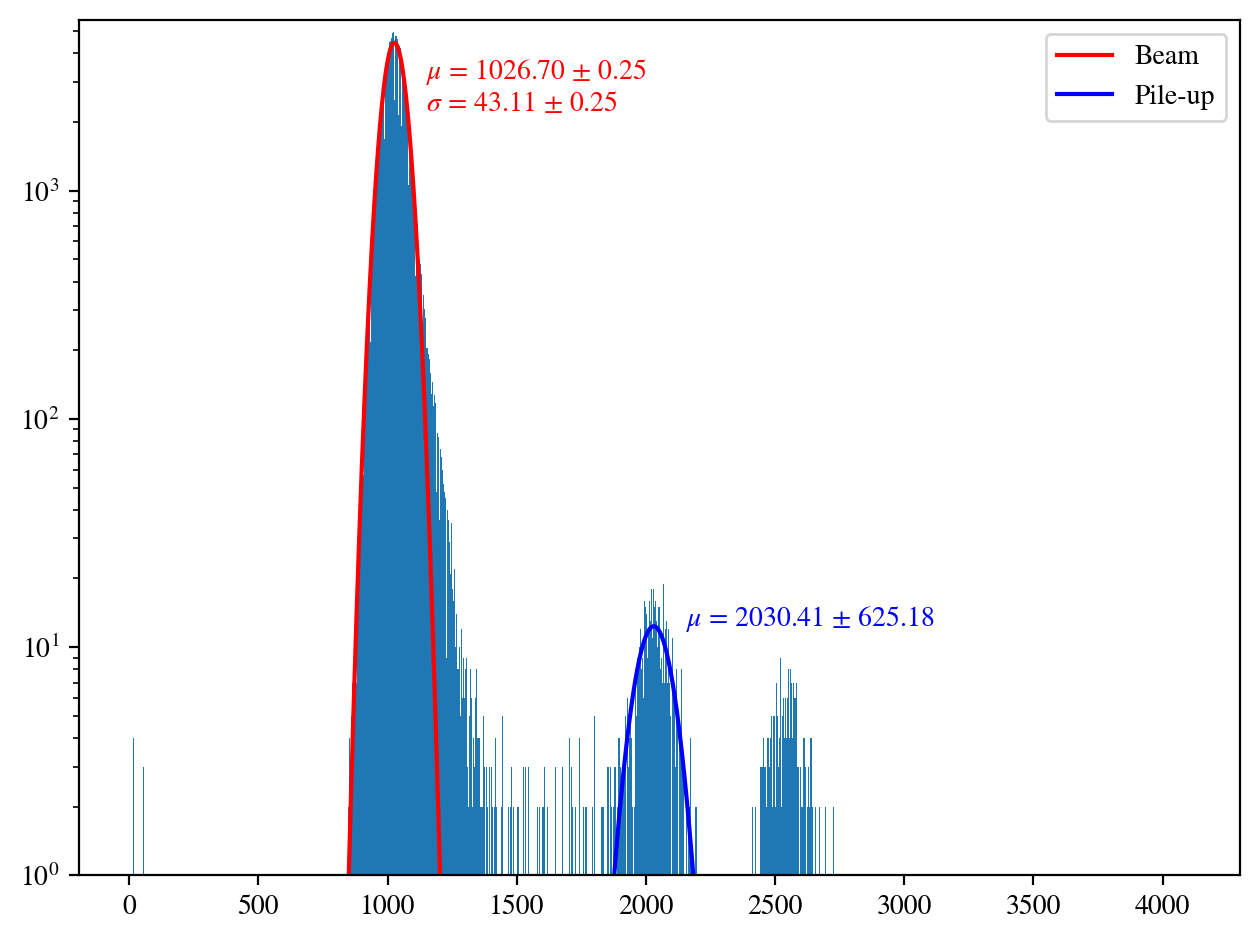

In [9]:
counts, bins, patches = plt.hist(df['s0'], bins='auto')

# Get center of bins
center_bins = (bins[:-1] + np.diff(bins) / 2)
# Fit peak at channel 1000
param_1, cov_1 = curve_fit(gauss, center_bins, counts,
                       p0=(4800, 1000, 50)) # initial guesses for peak at 1000
# Fit peak at channel 2000
param_2, cov_2 = curve_fit(gauss, center_bins, counts,
                       p0=(20, 2000, 50)) # initial guesses for peak at 2000
# Plot Gaussian curves
x_values_to_fit = np.linspace(500,3000,1000)
plt.plot(x_values_to_fit, gauss(x_values_to_fit, *param_1), '-', color = 'red', lw=1.5, label = "Beam")
plt.plot(x_values_to_fit, gauss(x_values_to_fit, *param_2), '-', color = 'blue', lw=1.5, label = "Pile-up")
# Put some parameters on graph
plt.text(param_1[1] + 100, param_1[0] - 0.5*param_1[0],
         f' $\mu$ = %.2f $\pm$ %.2f \n $\sigma$ = %.2f $\pm$ %.2f' % (param_1[1],
                                                                      np.sqrt(cov_1[1,1]),
                                                                      param_1[2],
                                                                      np.sqrt(cov_1[2,2])),
         color='red')
plt.text(param_2[1] + 100, param_2[0],
         f' $\mu$ = %.2f $\pm$ %.2f' % (param_2[1],
                                        np.sqrt(cov_2[1,1])),
         color='blue')

plt.yscale('log')
plt.ylim(1,5600)

plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
A few things about the above plot: first, we used the square root of the diagonal elements of the covariance matrix from our curve_fit to get error bars for the parameter values we put in the plot. Since we are just fitting a histogram, these error bars are fine. In general, this does not get you the "true" error bars, if the data you're fitting itself has errorbars you would need to incorporate that information into the fit and the resulting confidence of the parameters. It's just something to remember. Second, our y-axis is in a log scale. The "blue" peak is very small, so we shouldn't be surprised that the error bars for $\mu$ of the blue curve are quite large. This is also why I ommited the $\sigma$ for the blue curve, if you replot this with the y-axis on a linear scale the peak at 2000 is a mere blip.</div>

The peak at channel 1000 is fairly distinct from that at channel 2000. If we take the $\mu$ of the red curve and add two $\sigma$ to it (including the maximum error), we get something around channel 1114, which is still far away from the blue curve. Let's set the lower value of our cut at channel 500 and the upper value of the cut at channel 1114. A good habit to get into is to apply the cuts to a copy of the original data frame (that way, you always have both the cut and uncut data ). One way to do this is to use the "inplace" option.

In [10]:
# Note here the usage of the drop function. It seems backward at first, but checking the 
# dockstring the binary operator is the right way round

strip_0_cut = df.drop(df[500 > df.s0].index, # Nothing with strip 0 smaller than 500
                      inplace=False) # Do not make cut "inplace", make a copy of df called strip_0_cut first and cut on the copy
strip_0_cut.drop(strip_0_cut[strip_0_cut.s0 > 1114].index, # Nothing with strip 0 larger than 1114
                                inplace=True) # Do not make copy, make the cut "inplace"

strip_0_cut.describe()

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17,grid
count,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,...,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000
mean,1024.407593,349.425781,49.759960,36.895653,353.400391,365.808472,34.902157,37.019974,364.689667,401.401855,...,431.489288,37.836205,52.353367,441.170868,451.488464,35.252132,63.495564,432.270935,394.830872,1502.750488
std,40.848980,14.949155,9.006689,5.163402,15.926923,16.213142,6.546788,8.790931,17.918818,18.720455,...,24.890570,17.416399,59.185574,69.756538,28.063347,20.761753,74.801331,82.988930,15.948750,72.730820
min,537.000000,35.000000,33.000000,31.000000,36.000000,36.000000,28.000000,30.000000,31.000000,37.000000,...,33.000000,31.000000,29.000000,33.000000,34.000000,29.000000,31.000000,33.000000,27.000000,10.000000
25%,997.000000,340.000000,42.000000,36.000000,344.000000,356.000000,34.000000,36.000000,355.000000,391.000000,...,422.000000,36.000000,35.000000,441.000000,442.000000,33.000000,38.000000,436.000000,385.000000,1460.000000
50%,1025.000000,350.000000,50.000000,37.000000,354.000000,366.000000,35.000000,37.000000,365.000000,402.000000,...,432.000000,37.000000,37.000000,459.000000,453.000000,34.000000,40.000000,457.000000,395.000000,1501.000000
75%,1053.000000,359.000000,56.000000,38.000000,364.000000,376.000000,36.000000,38.000000,375.000000,413.000000,...,443.000000,38.000000,38.000000,473.000000,464.000000,35.000000,43.000000,471.000000,404.000000,1544.000000
max,1114.000000,693.000000,396.000000,625.000000,877.000000,869.000000,569.000000,426.000000,1028.000000,979.000000,...,1126.000000,1098.000000,849.000000,1229.000000,1129.000000,798.000000,1084.000000,1228.000000,951.000000,2679.000000


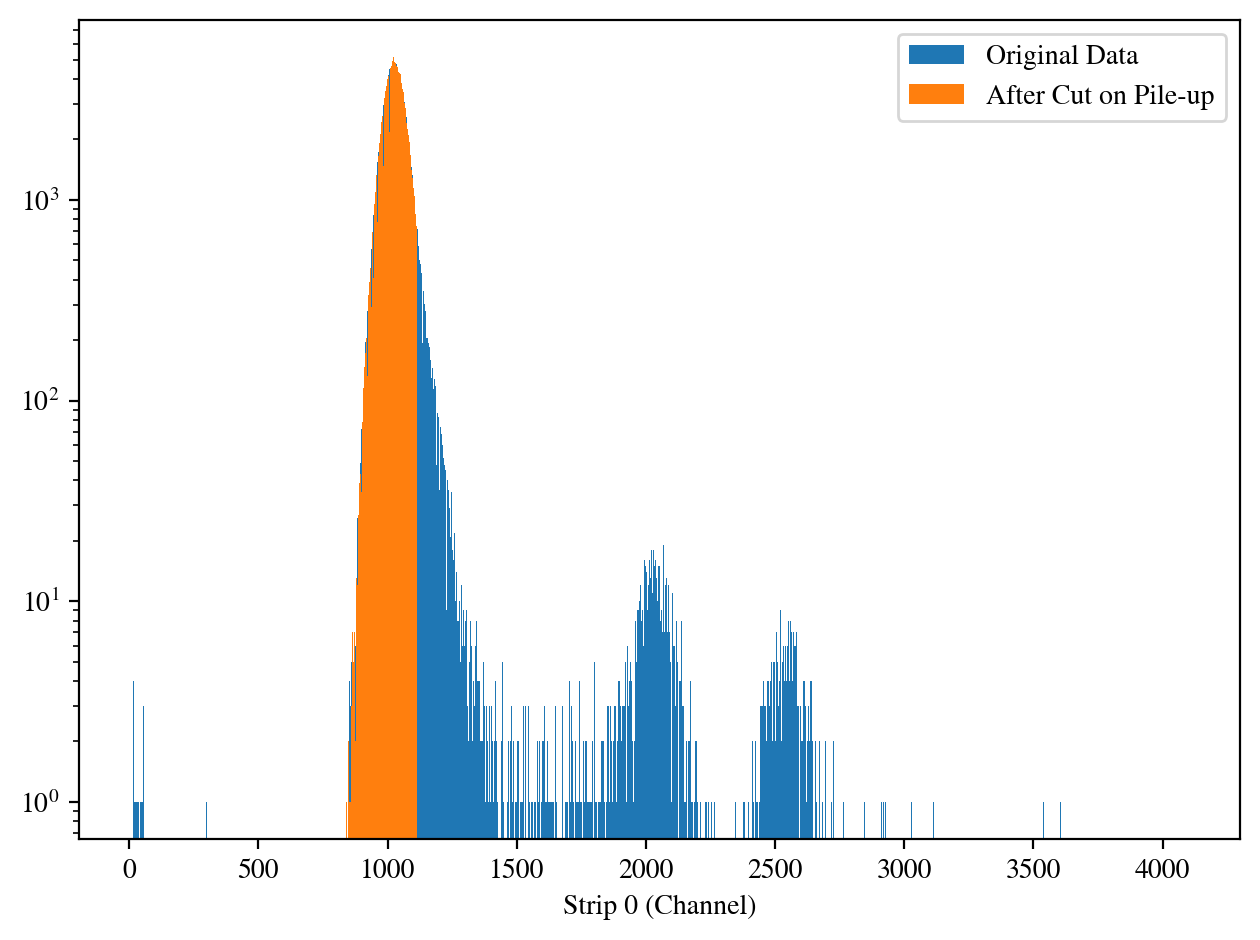

In [11]:
plt.hist(df['s0'], bins='auto',
         label='Original Data')
plt.hist(strip_0_cut['s0'], bins='auto',
         label='After Cut on Pile-up')

plt.xlabel('Strip 0 (Channel)')
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

Notice, after our cut, we still have what looks like a "wing" of events to the right of our upper cut limit. We made our cut based on the Gaussian fit (using $\mu$ plus two times the $\sigma$ of the Gaussian as a rough guide). This was to demonstrate cutting, not necessarily if this is the best possible cut for this data set. Double-checking where you place cuts and how that could influence your analysis needs to be handled on a case-by-case basis.  For this example we can move onto the next part.

# Normalizing the Anode Data

So far, we have only looked at strip 0. After making the cut to remove the pile-up events, we should look at the other histograms for the other strips. For simplicity, let's look at the next 8 long strips after strip 0. 

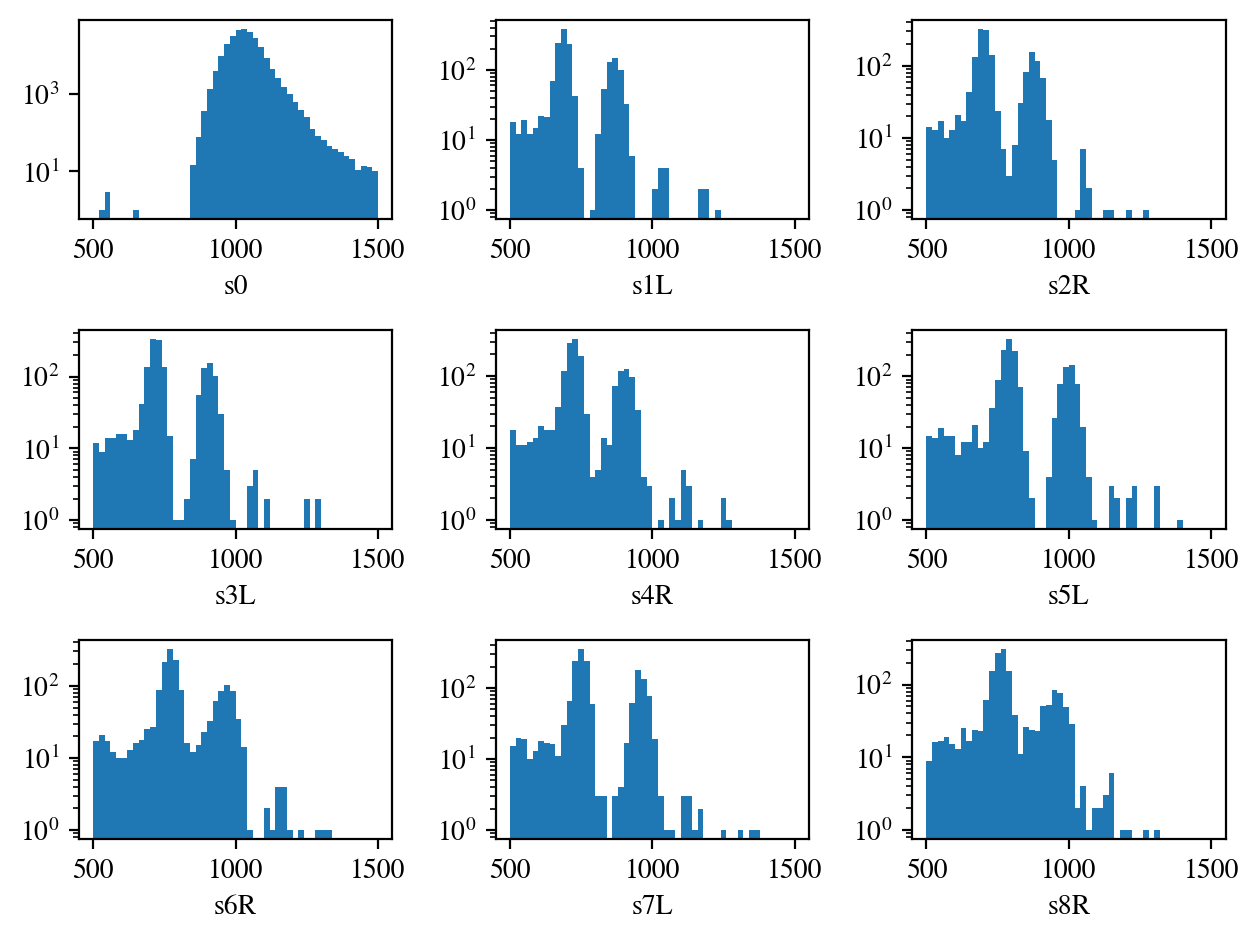

In [12]:
labels = ['s0', 's1L', 's2R', 's3L', 's4R', 's5L', 's6R', 's7L', 's8R']

fit, ax = plt.subplots(3,3)

for i in range(3):
    # top row
    ax[0,i].hist(df[labels[i]], bins=50, range=[500,1500])
    ax[0,i].set_xlabel(labels[i])
    ax[0,i].set_yscale('log')
    # middle row
    ax[1,i].hist(df[labels[i+3]], bins=50, range=[500,1500])
    ax[1,i].set_xlabel(labels[i+3])
    ax[1,i].set_yscale('log')
    # bottom row
    ax[2,i].hist(df[labels[i+6]], bins=50, range=[500,1500])
    ax[2,i].set_xlabel(labels[i+6])
    ax[2,i].set_yscale('log')
    
plt.tight_layout()
plt.show()

In the top left histogram we see strip 0 has the peak at 1000 and, aside from some skew towards higher channels, the distribution looks pretty Gaussian. However, looking at the remaining histograms, we see not one but two peaks. Of these two peaks, the most prominent one is not always centered at the same channel for these segmented anode strips. The most likely signal in all of the strips should be the unreacted beam. For this experiment we know

- The strips are all the same width
- The electric field should be sufficiently uniform (let's just take this as is for now, depending on beam rate and gas density, the dynamics of the ions and electric field can get complicated)
- The beam did not enter MUSIC at any appreciable angle
- The unreacted beam does not stop inside MUSIC 

then one could expect the unreacted beam to create a $\Delta$E signal in all of the strips centered at roughly the same channel. Which we don't see in the histograms we plotted above. Then, we will normalize our dataset using the unreacted beam signal in each of the anode strips. But, remember we have long strips (which see the unreacted beam) and short strips (which should not see the unreacted beam). Surely if there are differences in the gain of the long strips, there is differences in the gain for the short strips as well which we should "correct for" also. How do we handle this? Now we are getting into the nitty-gritty aspects of normalization. The short answer is, you need to try different normilzation schemes for your data set and see what gives a consistent result you are looking for. So, what we are going to do here won't always work. Though, the method we will use here is typically a good first thing to try on most MUSIC datasets. 

We will sum the left and right strips (s1L + s1R, s2L+s2R, etc...) and then normalize the summed data, using the unreacted beam peak, of each strip to some value of our choosing (say, 1000). First, let's create a new dataframe which has the left and right anode strips summed along the detector. Similar to how we build some of the dataframes in example 1, we can do this with a dictionary.

### Changing to Summed Strip DataFrame

In [13]:
# Strip 0
dict = {'s0':strip_0_cut['s0']}
# Segmented Anode
for i in range(1,17):
    dict.update({f's{i}': strip_0_cut[f's{i}L'] + strip_0_cut[f's{i}R'] })
# Strip 17 and Grid
dict.update({'s17':strip_0_cut['s17'], 'grid': strip_0_cut['grid']})


df_sum = pd.DataFrame(dict)

df_sum

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,grid
0,1003.0,416.0,401.0,420.0,377.0,410.0,411.0,417.0,433.0,456.0,451.0,426.0,497.0,497.0,492.0,495.0,494.0,402.0,1522.0
1,1091.0,397.0,403.0,408.0,397.0,398.0,436.0,392.0,410.0,408.0,449.0,458.0,465.0,466.0,563.0,502.0,522.0,380.0,1468.0
2,1083.0,426.0,395.0,406.0,410.0,394.0,406.0,401.0,427.0,443.0,444.0,441.0,485.0,484.0,539.0,503.0,522.0,402.0,1421.0
3,1002.0,405.0,378.0,394.0,417.0,441.0,435.0,428.0,401.0,443.0,451.0,458.0,506.0,472.0,479.0,503.0,504.0,400.0,1450.0
4,1015.0,393.0,398.0,410.0,421.0,439.0,413.0,411.0,438.0,391.0,422.0,451.0,479.0,477.0,478.0,476.0,506.0,366.0,1487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,401.0,396.0,418.0,413.0,450.0,444.0,405.0,407.0,423.0,423.0,446.0,492.0,464.0,467.0,454.0,498.0,403.0,1592.0
267825,969.0,366.0,396.0,422.0,399.0,444.0,383.0,419.0,419.0,413.0,419.0,450.0,469.0,475.0,496.0,482.0,517.0,384.0,1559.0
267826,958.0,376.0,395.0,394.0,398.0,432.0,415.0,402.0,411.0,430.0,434.0,465.0,473.0,459.0,481.0,456.0,497.0,398.0,1439.0
267827,1006.0,383.0,371.0,430.0,400.0,447.0,419.0,402.0,393.0,411.0,407.0,428.0,475.0,471.0,498.0,489.0,442.0,393.0,1524.0


### Normalizing By Fitting Gaussian to Unreacted Beam Peak

To get the factor we will apply to each strip to normalize the unreacted beam to 1000, we can fit the histogram of each strip by a Gaussian and, from the center parameter, derive a multiplicative factor to scale each strip. So we can see how this changes the data we can print some quick statistics about each column of the above summed dataframe with the "describe" function.

In [14]:
print('========== Non-Normalized Data ==========')
df_sum.describe()

========== Non-Normalized Data ==========


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,grid
count,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000
mean,1024.407593,399.185791,390.296082,400.710602,401.709686,432.986237,423.052277,412.402435,413.556458,422.556549,440.890747,441.377899,473.975159,469.325562,493.524231,486.740662,495.766479,394.830872,1502.750488
std,40.848980,16.109682,15.319316,14.935303,15.611171,16.691063,17.773767,16.370251,18.470634,16.514513,19.870636,16.811293,21.513346,17.414652,24.067612,18.168358,25.318844,15.948750,72.730820
min,537.000000,73.000000,71.000000,72.000000,70.000000,69.000000,70.000000,67.000000,65.000000,67.000000,67.000000,68.000000,70.000000,69.000000,69.000000,66.000000,71.000000,27.000000,10.000000
25%,997.000000,388.000000,380.000000,391.000000,392.000000,422.000000,412.000000,402.000000,402.000000,412.000000,430.000000,431.000000,462.000000,459.000000,480.000000,476.000000,481.000000,385.000000,1460.000000
50%,1025.000000,399.000000,391.000000,401.000000,402.000000,433.000000,423.000000,413.000000,414.000000,423.000000,442.000000,441.000000,475.000000,469.000000,495.000000,487.000000,497.000000,395.000000,1501.000000
75%,1053.000000,410.000000,401.000000,411.000000,412.000000,444.000000,435.000000,423.000000,426.000000,433.000000,453.000000,452.000000,488.000000,480.000000,509.000000,498.000000,511.000000,404.000000,1544.000000
max,1114.000000,747.000000,1176.000000,952.000000,1064.000000,1245.000000,1141.000000,1109.000000,1261.000000,1216.000000,1307.000000,1226.000000,1332.000000,1162.000000,1298.000000,1160.000000,1374.000000,951.000000,2679.000000


Now, we fit the histogram of each strip using a Gaussian, just like we did before we did the cut in strip 0. The one thing we need to remember is we need to be mindful of our initial guesses for the curve_fit function. For this simple example, I will manually enter some parameters (looking at each histogram and make reasonable guesses). There are ways to "automate" this guessing of the initial parameters, but that's something one can handle after you've done a couple of sets by hand.

<div class="alert alert-block alert-info">
For the example code below, we will continue using the plt.hist() function. The advantage of this is if you want to see what the normalization is doing by showing/saving the figures before you close them. However, as we noted once before, the Matplotlib hist functions invoke Numpy to handle the construction of the histogram (getting the counts and bins). So, one could modify this code to use np.histogram() instead if you don't want to make plots during the normalization.   </div>

In [15]:
norm_factor = []
norm_to = 1000.0
mu_guess = [1000.0, 380.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 420.0, 425.0,
            430.0, 435.0, 445.0, 455.0, 465.0, 475.0, 485.0, 380.0]

# Normalize a copy of the original dataframe
df_sum_norm = df_sum.copy()
# Da loop
for i in range(0,18):
    mean_gauss = 0.0
    counts, bins, patches = plt.hist(df_sum_norm.iloc[:, i], bins=60) # !
    cen_bins = (bins[:-1] + np.diff(bins) / 2)
    # Fit
    param, cov = curve_fit(gauss, cen_bins, counts,
                           p0=(35000, mu_guess[i], 25))
    # Get Mean of Gauss
    mean_gaus = param[1]
    # normalize
    norm_factor.append(norm_to/mean_gaus)
    df_sum_norm.iloc[:, i] = df_sum_norm.iloc[:, i]*(norm_to/mean_gaus)
    # Close
    plt.close()
    
print(norm_factor)
print('========== Normalized Data ==========')
df_sum_norm.describe()

[np.float64(0.9742297728147141), np.float64(2.500713690044033), np.float64(2.5621125454305647), np.float64(2.493693156011895), np.float64(2.487660702471855), np.float64(2.307194547814862), np.float64(2.3573740764919062), np.float64(2.4240125398022716), np.float64(2.4102981730941977), np.float64(2.3642416377172464), np.float64(2.2579835712752323), np.float64(2.263326192837205), np.float64(2.1021140797574684), np.float64(2.129278210227649), np.float64(2.0172679318989966), np.float64(2.0543371283395437), np.float64(2.0104951081710563), np.float64(2.534470986193736)]
========== Normalized Data ==========


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,grid
count,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000
mean,998.008362,998.249146,999.982361,999.249390,999.317322,998.983398,997.292542,999.668579,996.794250,999.025879,995.524048,998.982056,996.349670,999.324707,995.570618,999.929138,996.736145,1000.687378,1502.750488
std,39.796291,40.285702,39.249809,37.244064,38.835293,38.509529,41.899422,39.681686,44.519737,39.044296,44.867573,38.049438,45.223507,37.080639,48.550823,37.323929,50.903412,40.421646,72.730820
min,523.161377,182.552094,181.909988,179.545898,174.136246,159.196411,165.016190,162.408829,156.669373,158.404190,151.284912,153.906174,147.147980,146.920197,139.191483,135.586243,142.745163,68.430717,10.000000
25%,971.307068,970.276855,973.602783,975.033997,975.162964,973.636047,971.238159,974.453003,968.939819,974.067566,970.932983,975.493591,971.176636,977.338684,968.288635,977.864441,967.048157,975.771362,1460.000000
50%,998.585510,997.784729,1001.786011,999.970947,1000.039551,999.015198,997.169312,1001.117126,997.863403,1000.074219,998.028809,998.126831,998.504150,998.631470,998.547607,1000.462158,999.216125,1001.116089,1501.000000
75%,1025.863892,1025.292603,1027.407104,1024.907837,1024.916138,1024.394287,1025.457764,1025.357300,1026.786987,1023.716614,1022.866638,1023.023438,1025.831665,1022.053528,1026.789429,1023.059814,1027.363037,1023.926270,1544.000000
max,1085.291992,1868.033081,3013.044434,2373.995850,2646.870850,2872.457031,2689.763916,2688.229736,3039.385986,2874.917725,2951.184570,2774.837891,2800.015869,2474.221191,2618.413818,2383.031006,2762.420410,2410.281982,2679.000000


We can do a quick side-by-side plot to see what our normalization looks like.

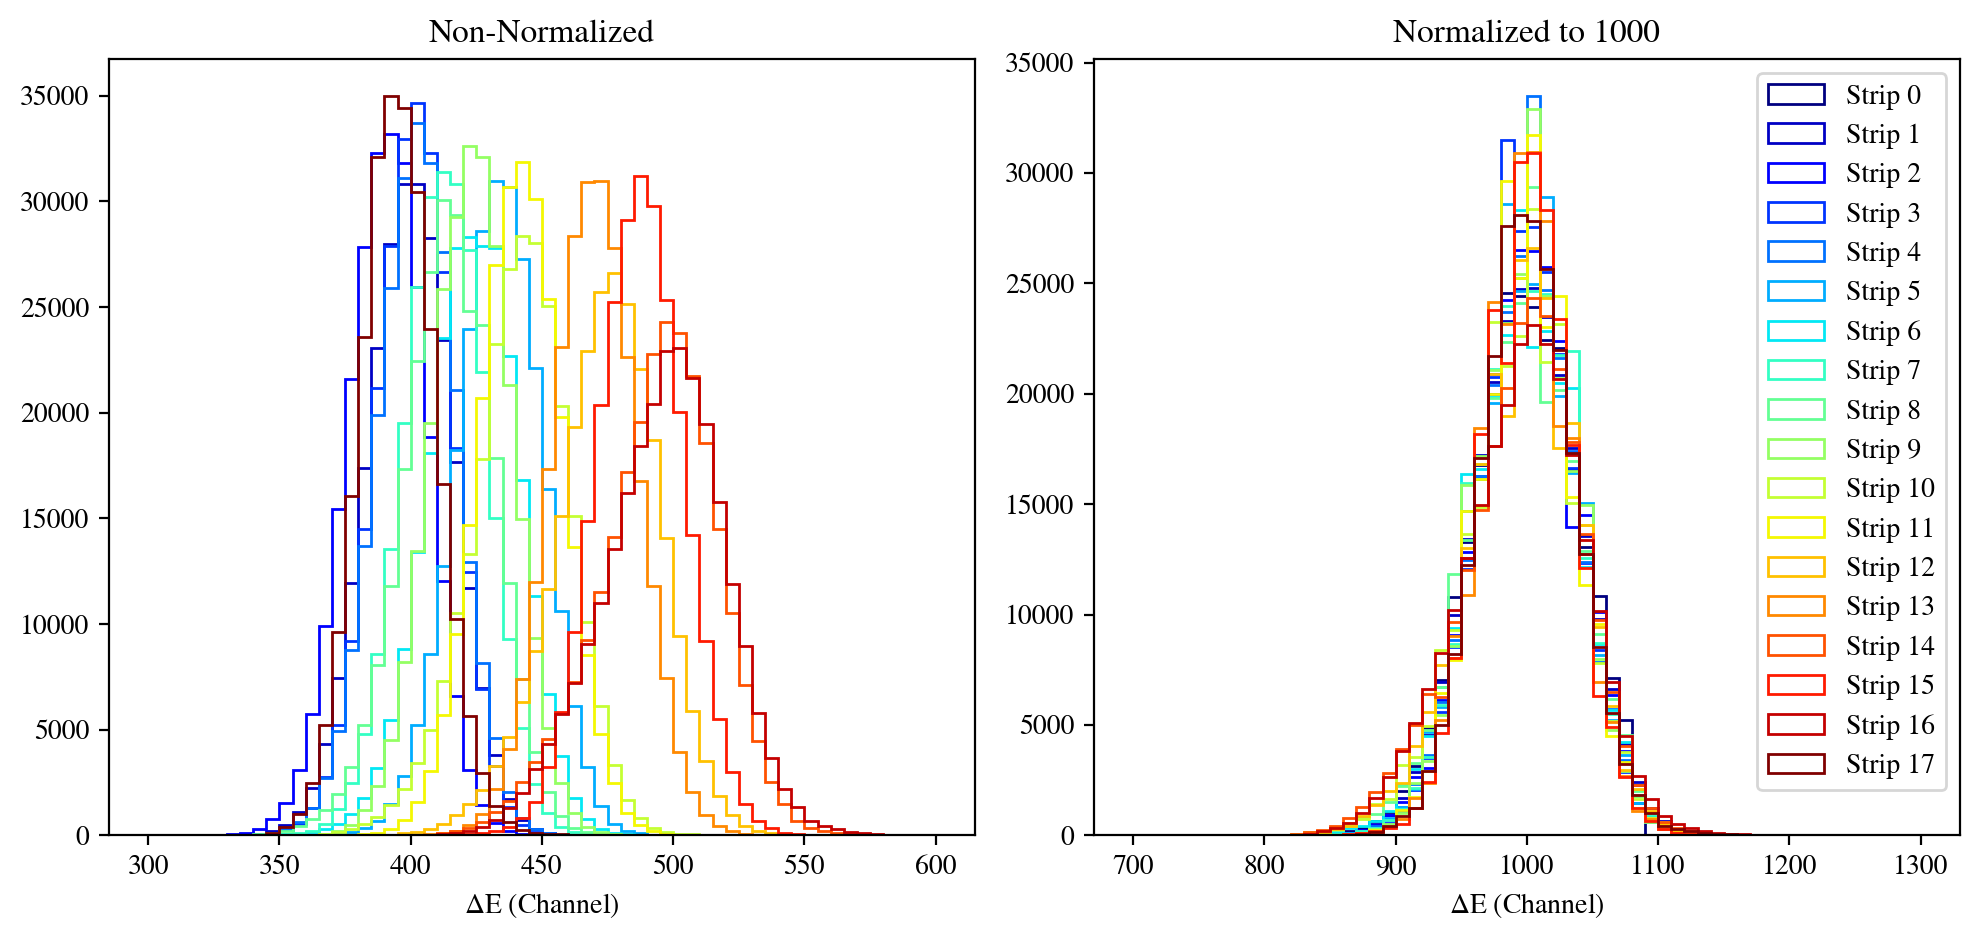

In [16]:
disc_jet = plt.cm.jet(np.linspace(0,1,18)) # Setup cmap so each histogram is unique color from jet

fig, ax = plt.subplots(1,2)
fig.set_figwidth(10,6)

for i in range(0,18):
    # Raw Data
    ax[0].hist(df_sum.iloc[:,i].values, bins=60, 
               range=[300, 600], 
               histtype='step',
               color=disc_jet[i],
               label=f'Strip {i}')
    # Normalized Data
    ax[1].hist(df_sum_norm.iloc[:,i].values, bins=60, 
               range=[700, 1300], 
               histtype='step',
               color=disc_jet[i],
               label=f'Strip {i}')

ax[0].set_title('Non-Normalized')
ax[0].set_xlabel(r'$\Delta$E (Channel)')

ax[1].set_title('Normalized to 1000')
ax[1].set_xlabel(r'$\Delta$E (Channel)')
ax[1].legend()

plt.tight_layout()
plt.show()

# Remove Bulk of Unreacted Beam

Now that we have normalized our data, we can use one very important piece of information to start removing beam-like events. That is, the majority of the fusions, or indeed most elastic scatters, if they take place in the beginning or middle parts of the detector, should at some point produce $\Delta$E signals that drop below the beam (in most cases, the signal should drop to zero at some point). For those fusion or elastic scatters which take place at the end of the detector, say the last 4 or 5 strips, the signal would most likely be above the beam (above channel 1000). However, potential events that take place in the last couple of strips are not easy to analyze (since you are in some sense "missing" part of the trace). So, for fusion data, you typically look at events in strips 1 - 10. 

So, we can remove those events that are beam-like in the last few strips of the detector. As usual, we will make a copy of the dataframe and then make the cut. If we just want a simple way to do this, we can extend the example of how we cut events in strip 0 by cutting on strip 17 first, looking at the change in the number of events that are left. We don't want to start out too aggressive with our cuts. So first let's see what the cut in strip 17 does. From the above histograms, after normalizing, it looks like the bulk of events are within channel 900 - 1100. Let us apply a cut in strip 17 which removes events with s17 > 900.

In [17]:
print('======================================================================')
print(f'Total "Raw" events = {len(df.index)}')
print('======================================================================')
print(f'Total events after strip 0 cut = {len(strip_0_cut.index)}')
print('======================================================================')
event_cut = df_sum_norm.drop(df_sum_norm[df_sum_norm.s17 > 900.0].index, # Nothing with strip 17 larger than 900
                             inplace=False) # Do not make cut "inplace", make a copy of original df to apply cut to
print(f'Total events also including strip 17 cut = {len(event_cut.index)}')
print('======================================================================')

Total "Raw" events = 267829
Total events after strip 0 cut = 252650
Total events also including strip 17 cut = 746


In [18]:
from matplotlib.colors import LogNorm

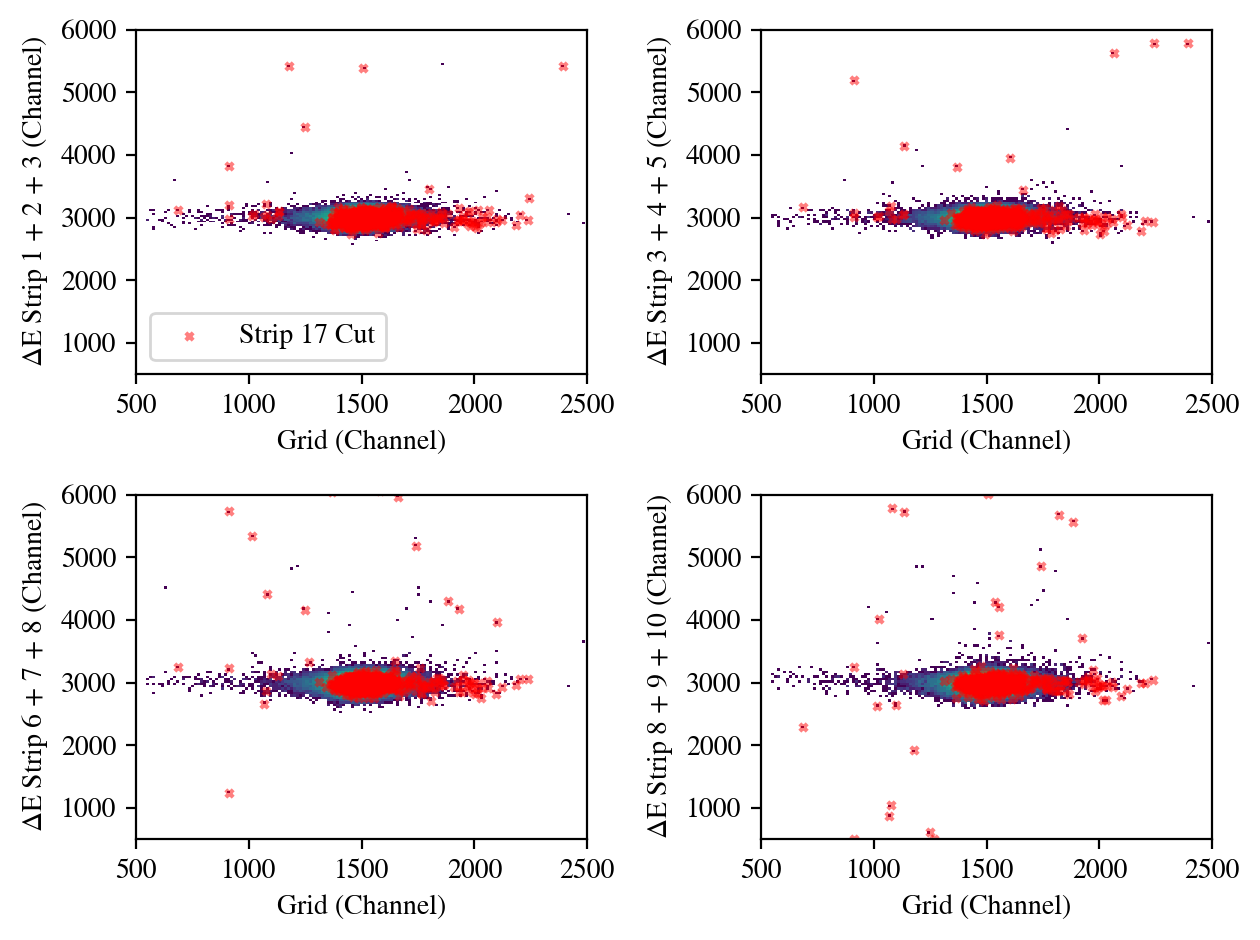

In [19]:
fig, ax = plt.subplots(2,2)

# Top row
ax[0,0].hist2d(df_sum_norm['grid'], df_sum_norm.iloc[:,1:4].sum(axis=1), bins=200, norm=LogNorm())
ax[0,0].scatter(event_cut['grid'], event_cut.iloc[:,1:4].sum(axis=1), marker='x', s=7, color='r', alpha=0.5, label='Strip 17 Cut')
ax[0,0].legend()
ax[0,0].set_ylabel(r'$\Delta$E Strip 1 + 2 + 3 (Channel)')
##
ax[0,1].hist2d(df_sum_norm['grid'], df_sum_norm.iloc[:,3:6].sum(axis=1), bins=200, norm=LogNorm())
ax[0,1].scatter(event_cut['grid'], event_cut.iloc[:,3:6].sum(axis=1), marker='x', s=7, color='r', alpha=0.5)
ax[0,1].set_ylabel(r'$\Delta$E Strip 3 + 4 + 5 (Channel)')
# Bottom row
ax[1,0].hist2d(df_sum_norm['grid'], df_sum_norm.iloc[:,6:9].sum(axis=1), bins=200, norm=LogNorm())
ax[1,0].scatter(event_cut['grid'], event_cut.iloc[:,6:9].sum(axis=1), marker='x', s=7, color='r', alpha=0.5)
ax[1,0].set_ylabel(r'$\Delta$E Strip 6 + 7 + 8 (Channel)')
##
ax[1,1].hist2d(df_sum_norm['grid'], df_sum_norm.iloc[:,8:11].sum(axis=1), bins=200, norm=LogNorm())
ax[1,1].scatter(event_cut['grid'], event_cut.iloc[:,8:11].sum(axis=1), marker='x', s=7, color='r', alpha=0.5)
ax[1,1].set_ylabel(r'$\Delta$E Strip 8 + 9 + 10 (Channel)')

for i in (0,1):
    for j in (0,1):
        ax[i,j].set_xlabel('Grid (Channel)')
        ax[i,j].set_xlim(500, 2500)
        ax[i,j].set_ylim(500, 6000)
        
    
plt.tight_layout()
plt.show()

In the plots above, we plotted a 2D histogram using the full normalized dataset after the strip 0 cut. The red $\times$'s are the events after the cut in strip 17. Each plot has the Frisch Grid (similar to total energy) along the x-axis, and along the y-axis are different combinations of three separate strips. In each plot, some of the red $\times$'s correspond to potential fusions, but in some of the clusters in each plot, they are more consistent with the beam. We normalized to 1000 in each strip, so the y-axis (the sum of three strips) will have the beam around channel 3000 in each plot. The choice of which three strips we picked will bias which events look more fusion-like. For example, we chose strips 1, 2, and 3 in the top right plot. The red $\times$'s clustered around y-value 3000 in the top right plot then correspond to those events that were beam-like at the front of the detector (beam-like in strips 1, 2, and 3) but have their jump after those three strips.

It might be more useful to check the traces since the potential fusions should be very distinct from the beam, and at a glance, you can tell roughly which strip the event started. After the strip 17 cut, we were left with about 700 events, which is not impossible to plot, but that many traces in one plot can get a little messy. However, we can use the numpy "where" function to try and auto-assign colors to groups of traces based on their values within certain strips. Let's take a quick look at the basics of the np.where() docstring to get an idea of how this will work.

In [25]:
import inspect
# let's look at the first 25 lines of the docstring for np.where() 
print('\n'.join(inspect.getdoc(np.where).splitlines()[0:25]))

where(condition, [x, y], /)

Return elements chosen from `x` or `y` depending on `condition`.

.. note::
    When only `condition` is provided, this function is a shorthand for
    ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
    preferred, as it behaves correctly for subclasses. The rest of this
    documentation covers only the case where all three arguments are
    provided.

Parameters
----------
condition : array_like, bool
    Where True, yield `x`, otherwise yield `y`.
x, y : array_like
    Values from which to choose. `x`, `y` and `condition` need to be
    broadcastable to some shape.

Returns
-------
out : ndarray
    An array with elements from `x` where `condition` is True, and elements
    from `y` elsewhere.



For example, let's plot the collection of traces after the cut in strip 17 and use the numpy.where() function to color-code some potential fusion-like events in strip 3. To make things a little easier to see we can also play with the alpha (transparancy) of some of the traces in addition to using zorder to force Matplotlib to plot certain traces last (so, print objects with higher zorder on top of those objects with smaller values of zorder).

In [26]:
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

100%|███████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 1485.08it/s]


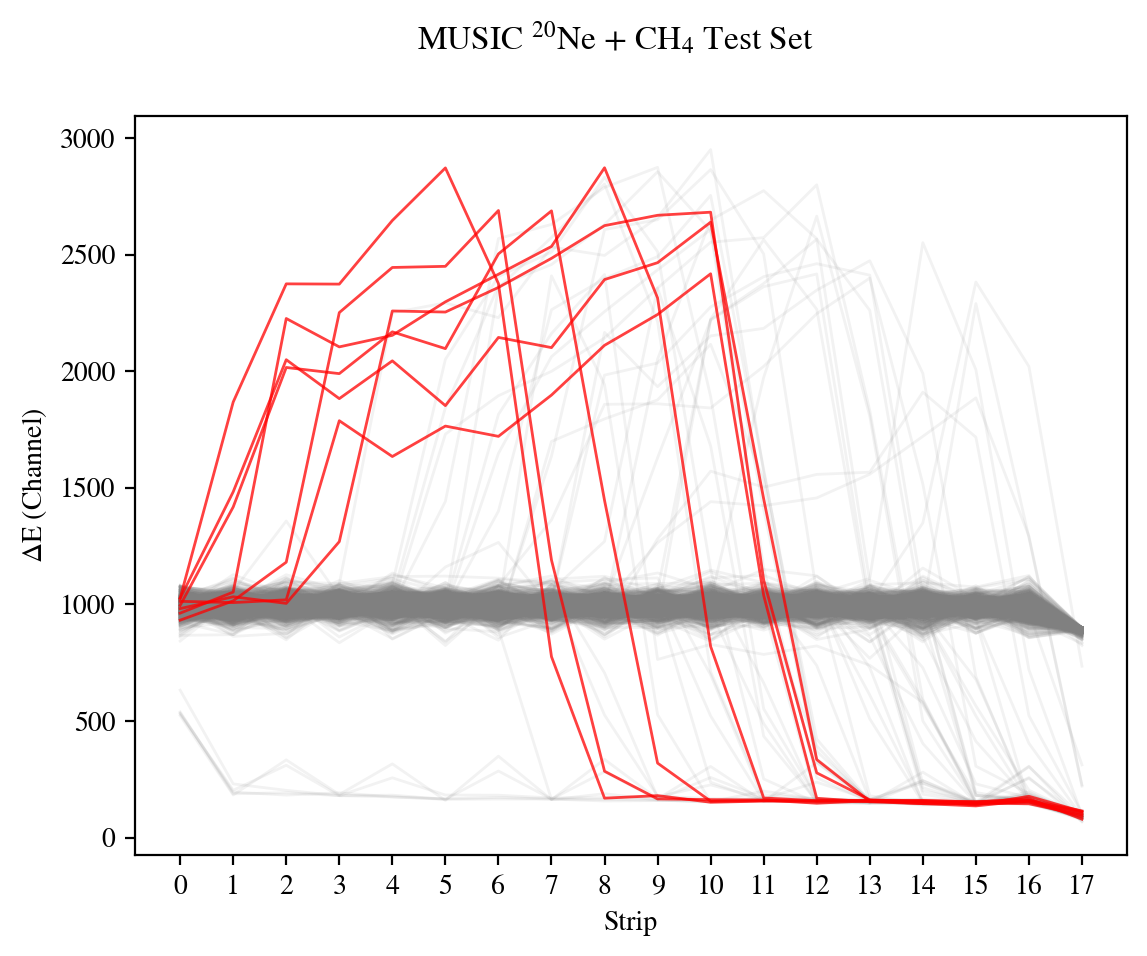

In [27]:
# for color, if strip 3 > 1200.0 color the trace red otherwise color trace grey
color = np.where(event_cut['s3'] > 1200.0, 'red', 'grey') 
# for alpha, if strip 3 > 1200.0 set alpha=0.75 (75% transparency) otherwise draw the trace with alpha=0.10
alpha = np.where(event_cut['s3'] > 1200.0, 0.75, 0.10)
# for zorder, if strip 3 > 1200.0 set the zorder of the trace at 100 otherwise set the zorder to 1 (higher zorder is drawn on top of lower zorder) 
zorder = np.where(event_cut['s3'] > 1200.0, 100, 1)

strip_num = np.arange(0,18,1)

fig, ax = plt.subplots()
fig.suptitle(r'MUSIC $^{20}$Ne + CH$_{4}$ Test Set')
# loop over the traces
for i in tqdm(range(len(event_cut.index))):
    ax.plot(strip_num,
            event_cut.iloc[i,0:18],
            color=color[i], # use the 'color' array we made with np.where to set the color of the ith trace
            alpha=alpha[i], 
            linewidth=1,
            zorder=zorder[i])

ax.set_xlabel('Strip')
ax.xaxis.set_major_locator(MaxNLocator(nbins=20)) # major x-axis ticks at integer values (one of many ways to do this)
ax.set_ylabel(r'$\Delta$E (Channel)')
plt.show()

We have some traces which look like good potential fuson events. However, we can also see our choice for setting the color of the traces using only the value of strip 3 got us what looks like events in strip 1 and 2 as well. Clearly, we will need more cuts to narrow down events to a particular strip. But, one advantage of this type of "simple graphical" method gives a quick way to test cuts and play around with the data. For example, we can add one more "cut" to just see the events in strip 3. Let's nest our previous np.where() function inside another. We will only color red the traces that are both below 1200 in strip 2 and also above 1200 in strip 3. We can then modify what we did for the trace color for setting the alpha and the zorder too.

100%|███████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 1621.72it/s]


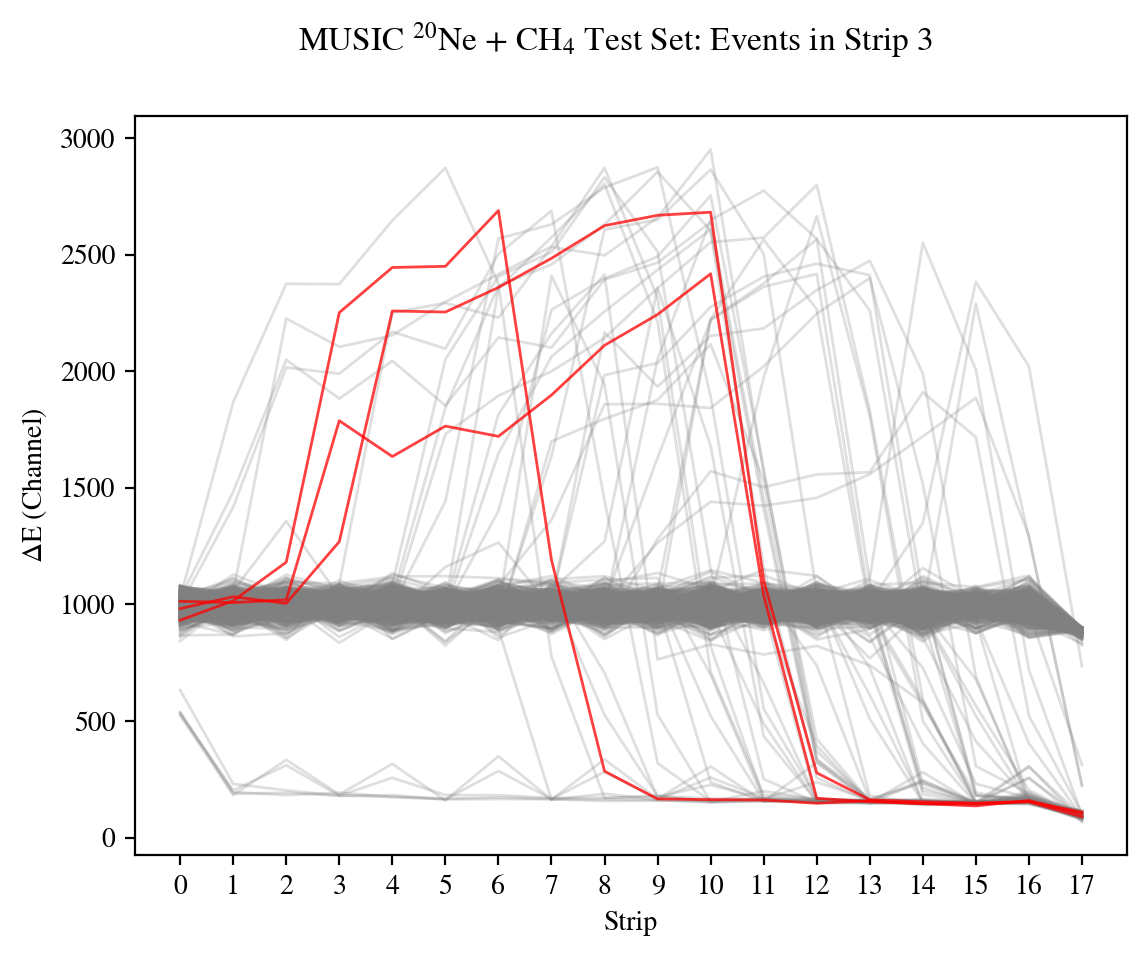

In [33]:
color = np.where(event_cut['s2'] < 1200.0, np.where(event_cut['s3'] > 1200.0, 'red', 'grey'), 'grey') 
alpha = np.where(event_cut['s2'] < 1200.0, np.where(event_cut['s3'] > 1200.0, 0.75, 0.25), 0.25) 
zorder = np.where(event_cut['s2'] < 1200.0, np.where(event_cut['s3'] > 1200.0, 100, 1), 1) 

strip_num = np.arange(0,18,1)

fig, ax = plt.subplots()
fig.suptitle(r'MUSIC $^{20}$Ne + CH$_{4}$ Test Set: Events in Strip 3')
# loop over the traces
for i in tqdm(range(len(event_cut.index))):
    ax.plot(strip_num,
            event_cut.iloc[i,0:18],
            color=color[i], # use the 'color' array we made with np.where to set the color of the ith trace
            alpha=alpha[i], 
            linewidth=1,
            zorder=zorder[i])

ax.set_xlabel('Strip')
ax.xaxis.set_major_locator(MaxNLocator(nbins=20)) # major x-axis ticks at integer values (one of many ways to do this)
ax.set_ylabel(r'$\Delta$E (Channel)')
plt.show()

Another example would be wrapping this into a for loop to look at events across a couple different traces. For example, using a 2x2 plot to see events in strips 2 - 5. In the previous plot we also see we should probably tighten one of our cuts, when we check the previous strip let's set the limit a little lower to 1100.

100%|███████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 1980.21it/s]


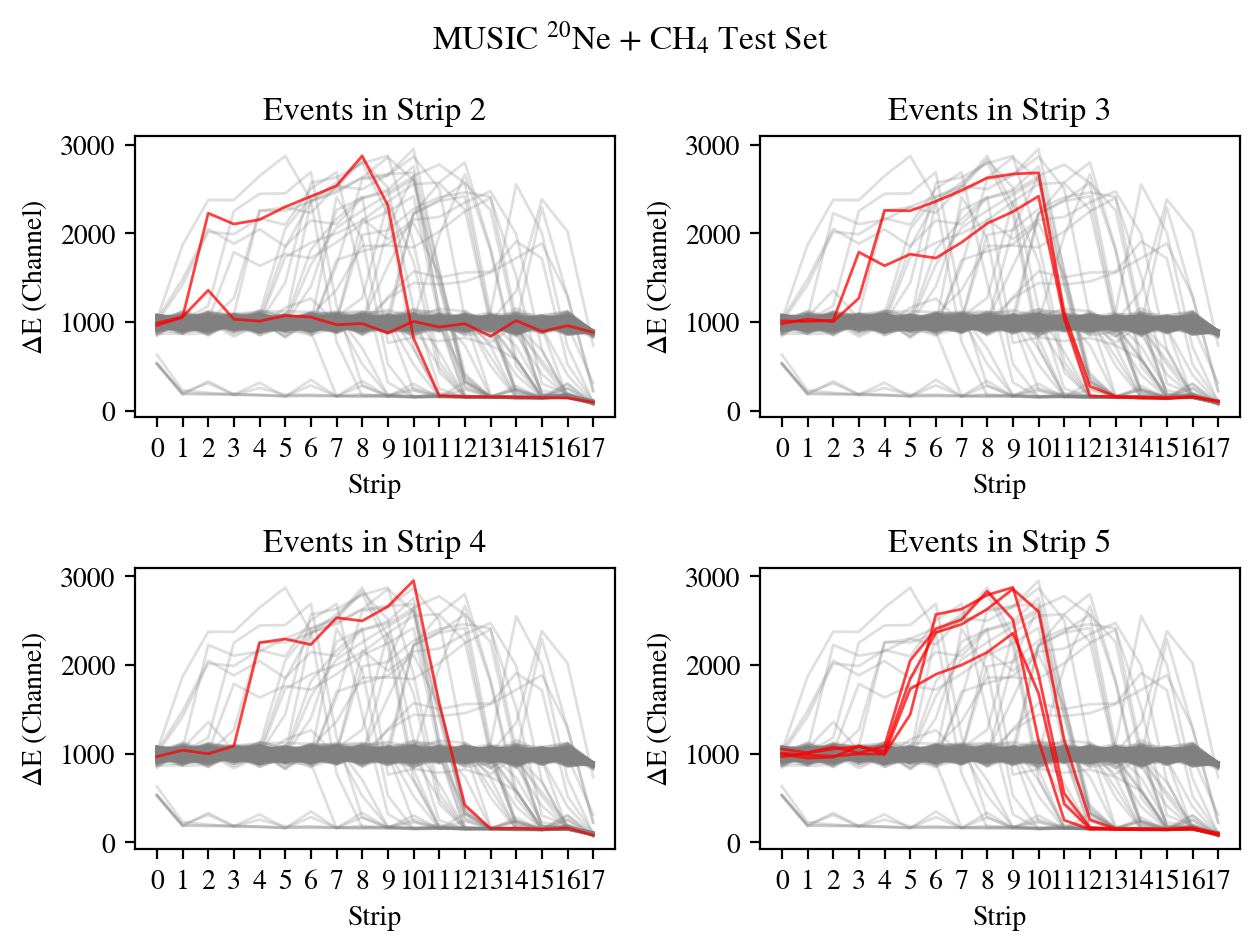

In [37]:
strip_num = np.arange(0,18,1)
row_ix = (0,0,1,1)
col_ix = (0,1,0,1)

fig, ax = plt.subplots(2,2)
fig.suptitle(r'MUSIC $^{20}$Ne + CH$_{4}$ Test Set')

for i in (2,3,4,5):
    #
    color = np.where(event_cut[f's{i-1}'] < 1100.0, np.where(event_cut[f's{i}'] > 1200.0, 'red', 'grey'), 'grey') 
    alpha = np.where(event_cut[f's{i-1}'] < 1100.0, np.where(event_cut[f's{i}'] > 1200.0, 0.75, 0.25), 0.25) 
    zorder = np.where(event_cut[f's{i-1}'] < 1100.0, np.where(event_cut[f's{i}'] > 1200.0, 100, 1), 1) 
    #
    ax[row_ix[i-2],col_ix[i-2]].set_title(f'Events in Strip {i}')
    # loop over the traces
    for j in tqdm(range(len(event_cut.index))):
        ax[row_ix[i-2],col_ix[i-2]].plot(strip_num,
                   event_cut.iloc[j,0:18],
                   color=color[j],
                   alpha=alpha[j], 
                   linewidth=1,
                   zorder=zorder[j])
    #
    ax[row_ix[i-2],col_ix[i-2]].set_xlabel('Strip')
    ax[row_ix[i-2],col_ix[i-2]].xaxis.set_major_locator(MaxNLocator(nbins=20)) # major x-axis ticks at integer values (one of many ways to do this)
    ax[row_ix[i-2],col_ix[i-2]].set_ylabel(r'$\Delta$E (Channel)')

plt.tight_layout()
plt.show()

Making plots this way works well with a small set of traces (on the order of a thousand or less). But, if can give you an idea or where to make cuts on the full dataset using something like the pandas drop function. We can now put all of this information into a sort of psuedo-algorithm for finding events in MUSIC fusion data. 

1. After pulling the data into a dataframe, cut on strip 0 to remove pile-up events using the pandas drop function.
2. Normalize each of the strips.
3. Grab a subset (say 1000 events pulled randomly) of the full normalized dataframe, something like:  
    ```python
        df_testset = your_dataframe.sample(n=1000)  
    ```
  
4. With this subset, make some plots using the np.where() method and play around with different cuts.
5. Once you have an idea of where you want to place the cuts in each strip, create a copy of the full dataframe to apply the cuts on:  
    ```python
        # make copy, and apply first cut
        df_events = yourdataframe.drop(yourdataframe[yourdataframe.strip {>, =, <, etc...} cut_value].index, inplace=False) 
        # apply subsequent cuts to the copy
        df_events.drop(df_events[df_events.strip  {>, =, <, etc...} cut_value].index, inplace=True)
    ```
  
6. Make some more plots, like $\Delta$E-TotE, $\Delta$E-$\Delta$E plots using different combinations of strips, or plot some more traces. If you are happy with what you see, time to move on to crunching numbers to get a preliminary cross section (you have events, but haven't yet seperated all of the elastic scatters from the fusions). In any case, you can run through the process again from step 3, grab a different subset of traces and play with different cuts.
